## Colab 설정 및 필요 라이브러리 설치

## 라이브러리 로드

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import datetime
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_absolute_error

from mlxtend.preprocessing import minmax_scaling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') 

import lightgbm as lgb
from xgboost import XGBRegressor

In [2]:
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', None)
path = "/gdrive/My Drive/Brunch/"

### 데이터 로드

In [3]:
import pyupbit

coins = pyupbit.get_tickers(fiat="KRW")
len(coins)

114

In [62]:
## 코인 거래 데이터 다운로드를 위한 함수 설정

def get_df(coin):
#     df = pyupbit.get_ohlcv(coin, count=365) # 1년치 데이터 활용
#     df_4h = pyupbit.get_ohlcv(coin, interval = 'minute240', count=365*6) # 240분 단위 데이터 활용

    df = pyupbit.get_ohlcv(coin, interval = 'minute5', count=10*24*12) # 5분 단위 데이터
    df_4h = pyupbit.get_ohlcv(coin, interval = 'minute5', count=10*24*12) # 5분 단위 데이터
    
    ## 변수 생성
    ## RSI 지표 생성
    df_4h['U'] = df_4h['close'] - df_4h['open']
    df_4h['D'] = df_4h['close'] - df_4h['open']
    df_4h['U'] = np.where(df_4h['U'] > 0, df_4h['U'], 0)
    df_4h['D'] = np.where(df_4h['D'] < 0, df_4h['D'], 0)

    df_4h.index = df_4h.index.strftime("%Y%m%d%H%M")
    df.index = df.index.strftime("%Y%m%d%H%M")

    df_A = df_4h.reset_index().groupby('index').mean()[['U','D']].reset_index()
    df_A.columns = ['index','AU','AD']

    df = pd.merge(df.reset_index(), df_A, on='index', how='left')
    df['price'] = df['close']*100 / df['open']

    df['RSI'] = df['AU'] / (df['AU'] + df['AD'])
    df.drop(['open','high','low','volume','AU','AD'], axis=1, inplace=True)
    
    for i in df.index:
        cur_rsi = df.loc[i, 'RSI']
        try:
            int(cur_rsi)
        except:
            df.loc[i, 'RSI'] = 0.0
        
    df['RSI'] = df['RSI'].apply(lambda x: df[np.isnan(df['RSI'])].max()['RSI'] if np.isnan(x) else x)
    df['RSI'].describe()

    ## 각 변수의 과거 시점 값을 변수로 생성
    df = pd.concat([df[['index','close','price']],minmax_scaling(df, columns=['value','RSI'])], axis=1)
    lag = np.arange(1,30).tolist()

    close_cols = ['close_' + str(a) for a in lag]
    value_cols = ['value_' + str(a) for a in lag]
    RSI_cols = ['RSI_' + str(a) for a in lag]

    data = pd.DataFrame()
    data['date'] = df['index']
    data['name'] = coin.split('-')[1]

    data['close'] = df['close']
    data['value'] = df['value']
    data['RSI'] = df['RSI']

    for a,b,c,d in zip(lag, close_cols, value_cols, RSI_cols):
        data[b] = df['close'].shift(int(a))
        data[c] = df['value'].shift(int(a))
        data[d] = df['RSI'].shift(int(a))

    time_now = datetime.datetime.now() + datetime.timedelta(days=-1)
    time_now = time_now.strftime("%Y%m%d")

    ## 5일 뒤 종가를 예측 변수로 설정
    ## 1시간 뒤의 종가를 예측 변수로 변경함
    data['target'] = df['close'].shift(-12) # 5분 * 12 = 60분
    data['target'] = data['target']*100 / df['close']

    data['target'] = np.where(data['date'] <= time_now, data['target'], 100)

    data = data.dropna(axis=0)
    data.reset_index(drop = True, inplace=True)

    return data

In [63]:
## 설정 함수를 이용한 실제 데이터 셋 생성
df = pd.DataFrame()

for coin in tqdm(coins):
    tmp = get_df(coin)
    df = pd.concat([df,tmp])
    break

df.reset_index(drop = True, inplace=True)

  0%|                                                                                          | 0/114 [00:11<?, ?it/s]


In [64]:
df[np.isnan(df['RSI'])]

,date,name,close,value,RSI,close_1,value_1,RSI_1,close_2,value_2,RSI_2,close_3,value_3,RSI_3,close_4,value_4,RSI_4,close_5,value_5,RSI_5,close_6,value_6,RSI_6,close_7,value_7,RSI_7,close_8,value_8,RSI_8,close_9,value_9,RSI_9,close_10,value_10,RSI_10,close_11,value_11,RSI_11,close_12,value_12,RSI_12,close_13,value_13,RSI_13,close_14,value_14,RSI_14,close_15,value_15,RSI_15,close_16,value_16,RSI_16,close_17,value_17,RSI_17,close_18,value_18,RSI_18,close_19,value_19,RSI_19,close_20,value_20,RSI_20,close_21,value_21,RSI_21,close_22,value_22,RSI_22,close_23,value_23,RSI_23,close_24,value_24,RSI_24,close_25,value_25,RSI_25,close_26,value_26,RSI_26,close_27,value_27,RSI_27,close_28,value_28,RSI_28,close_29,value_29,RSI_29,target


In [65]:
df

,date,name,close,value,RSI,close_1,value_1,RSI_1,close_2,value_2,RSI_2,close_3,value_3,RSI_3,close_4,value_4,RSI_4,close_5,value_5,RSI_5,close_6,value_6,RSI_6,close_7,value_7,RSI_7,close_8,value_8,RSI_8,close_9,value_9,RSI_9,close_10,value_10,RSI_10,close_11,value_11,RSI_11,close_12,value_12,RSI_12,close_13,value_13,RSI_13,close_14,value_14,RSI_14,close_15,value_15,RSI_15,close_16,value_16,RSI_16,close_17,value_17,RSI_17,close_18,value_18,RSI_18,close_19,value_19,RSI_19,close_20,value_20,RSI_20,close_21,value_21,RSI_21,close_22,value_22,RSI_22,close_23,value_23,RSI_23,close_24,value_24,RSI_24,close_25,value_25,RSI_25,close_26,value_26,RSI_26,close_27,value_27,RSI_27,close_28,value_28,RSI_28,close_29,value_29,RSI_29,target
0,202301082345,BTC,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,21562000.0,0.004672,0.0,21563000.0,0.008012,0.0,21563000.0,0.006417,0.0,100.106575
1,202301082350,BTC,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,21562000.0,0.004672,0.0,21563000.0,0.008012,0.0,100.101979
2,202301082355,BTC,21572000.0,0.008978,0.0,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,21562000.0,0.004672,0.0,100.203968
3,202301090000,BTC,21577000.0,0.011080,1.0,21572000.0,0.008978,0.0,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,100.227094
4,202301090005,BTC,21578000.0,0.002406,0.0,21577000.0,0.011080,1.0,21572000.0,0.008978,0.0,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.

In [66]:
for i in df.index:
    cur_rsi = df.loc[i, 'RSI']

    try:
        int(cur_rsi)
    except:
        df.loc[i, 'RSI'] = 0.0
        
df

,date,name,close,value,RSI,close_1,value_1,RSI_1,close_2,value_2,RSI_2,close_3,value_3,RSI_3,close_4,value_4,RSI_4,close_5,value_5,RSI_5,close_6,value_6,RSI_6,close_7,value_7,RSI_7,close_8,value_8,RSI_8,close_9,value_9,RSI_9,close_10,value_10,RSI_10,close_11,value_11,RSI_11,close_12,value_12,RSI_12,close_13,value_13,RSI_13,close_14,value_14,RSI_14,close_15,value_15,RSI_15,close_16,value_16,RSI_16,close_17,value_17,RSI_17,close_18,value_18,RSI_18,close_19,value_19,RSI_19,close_20,value_20,RSI_20,close_21,value_21,RSI_21,close_22,value_22,RSI_22,close_23,value_23,RSI_23,close_24,value_24,RSI_24,close_25,value_25,RSI_25,close_26,value_26,RSI_26,close_27,value_27,RSI_27,close_28,value_28,RSI_28,close_29,value_29,RSI_29,target
0,202301082345,BTC,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,21562000.0,0.004672,0.0,21563000.0,0.008012,0.0,21563000.0,0.006417,0.0,100.106575
1,202301082350,BTC,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,21562000.0,0.004672,0.0,21563000.0,0.008012,0.0,100.101979
2,202301082355,BTC,21572000.0,0.008978,0.0,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,21562000.0,0.004672,0.0,100.203968
3,202301090000,BTC,21577000.0,0.011080,1.0,21572000.0,0.008978,0.0,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.0,0.006352,0.0,21576000.0,0.003818,1.0,21582000.0,0.004495,1.0,21572000.0,0.008411,0.0,21573000.0,0.005475,0.0,21578000.0,0.003539,0.0,21579000.0,0.003876,1.0,21565000.0,0.002263,0.0,21571000.0,0.009543,0.0,21577000.0,0.003445,0.0,21581000.0,0.011455,0.0,21583000.0,0.008028,1.0,21579000.0,0.003961,0.0,21582000.0,0.006765,0.0,21582000.0,0.005555,0.0,21572000.0,0.013356,1.0,21571000.0,0.005172,0.0,21583000.0,0.008858,1.0,21574000.0,0.003855,1.0,21571000.0,0.013588,1.0,21575000.0,0.004873,1.0,100.227094
4,202301090005,BTC,21578000.0,0.002406,0.0,21577000.0,0.011080,1.0,21572000.0,0.008978,0.0,21573000.0,0.009909,0.0,21581000.0,0.005376,1.0,21581000.0,0.006319,1.0,21574000.0,0.003692,0.0,21582000.0,0.003453,1.0,21580000.0,0.003458,0.0,21580000.0,0.004496,1.0,21574000.

### 머신러닝 모델링

In [67]:
## 학습, 예측 셋 구분 (최근 5일치 기준)
time_now = datetime.datetime.now() + datetime.timedelta(days=-1)
time_now = time_now.strftime("%Y%m%d")

time_now

'20230117'

In [68]:
## 학습, 예측 셋 구분 (최근 5일치 기준)
time_now = datetime.datetime.now() + datetime.timedelta(days=-1)
time_now = time_now.strftime("%Y%m%d")

Train = df[df['date'] <= time_now]
Test = df[df['date'] > time_now]

Train.reset_index(drop = True, inplace=True)
Test.reset_index(drop = True, inplace=True)

## 활용 변수 셋팅
cols = df.columns.tolist()
cols.remove('target')
cols.remove('name')
cols.remove('date')

## 학습용, 검증용 데이터셋 분리
X_train, X_valid, y_train, y_valid = train_test_split(Train[cols], Train['target'], train_size=0.8,random_state=42)

In [69]:
Test

,date,name,close,value,RSI,close_1,value_1,RSI_1,close_2,value_2,RSI_2,close_3,value_3,RSI_3,close_4,value_4,RSI_4,close_5,value_5,RSI_5,close_6,value_6,RSI_6,close_7,value_7,RSI_7,close_8,value_8,RSI_8,close_9,value_9,RSI_9,close_10,value_10,RSI_10,close_11,value_11,RSI_11,close_12,value_12,RSI_12,close_13,value_13,RSI_13,close_14,value_14,RSI_14,close_15,value_15,RSI_15,close_16,value_16,RSI_16,close_17,value_17,RSI_17,close_18,value_18,RSI_18,close_19,value_19,RSI_19,close_20,value_20,RSI_20,close_21,value_21,RSI_21,close_22,value_22,RSI_22,close_23,value_23,RSI_23,close_24,value_24,RSI_24,close_25,value_25,RSI_25,close_26,value_26,RSI_26,close_27,value_27,RSI_27,close_28,value_28,RSI_28,close_29,value_29,RSI_29,target
0,202301170000,BTC,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,25881000.0,0.025026,0.0,25887000.0,0.021436,0.0,25892000.0,0.023871,0.0,100.0
1,202301170005,BTC,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,25881000.0,0.025026,0.0,25887000.0,0.021436,0.0,100.0
2,202301170010,BTC,25755000.0,0.103477,0.0,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,25881000.0,0.025026,0.0,100.0
3,202301170015,BTC,25893000.0,0.051107,1.0,25755000.0,0.103477,0.0,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,100.0
4,202301170020,BTC,26012000.0,0.075129,1.0,25893000.0,0.051107,1.0,25755000.0,0.103477,0.0,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946

In [70]:
## XGB를 이용한 머신러닝
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_valid)
print(mean_absolute_error(y_valid, y_pred))

0.2913615103042029


In [71]:
## 예측값과 실제값의 차이 확인
tmp = pd.DataFrame()
tmp['pred'] = y_pred
tmp['true'] = y_valid

## 예측이 잘 된 경우와 되지 않은 경우 확인
tmp['diff'] = abs(tmp['pred'] - tmp['true'])
display(tmp.sort_values('diff', ascending = True).head(10), tmp.sort_values('diff', ascending = False).head(10))

,pred,true,diff
48,99.994186,99.990729,0.003457
290,99.898254,99.903497,0.005243
368,99.877182,99.871134,0.006048
367,99.873138,99.880295,0.007156
69,99.998711,100.009276,0.010565
70,99.931587,99.944385,0.012798
289,100.065300,100.050558,0.014742
196,99.951019,99.935418,0.015601
25,99.912506,99.944406,0.031900
111,99.980217,99.944772,0.035445


,pred,true,diff
203,98.512215,100.009225,1.497010
100,101.963692,100.476367,1.487325
240,99.038452,100.349184,1.310732
134,100.949516,99.912591,1.036925
457,101.236000,100.213002,1.022998
219,99.376053,100.392085,1.016032
230,99.073196,100.041362,0.968166
76,100.992340,100.111348,0.880992
96,99.660378,100.440815,0.780437
342,100.378403,99.633213,0.745190


<AxesSubplot:>

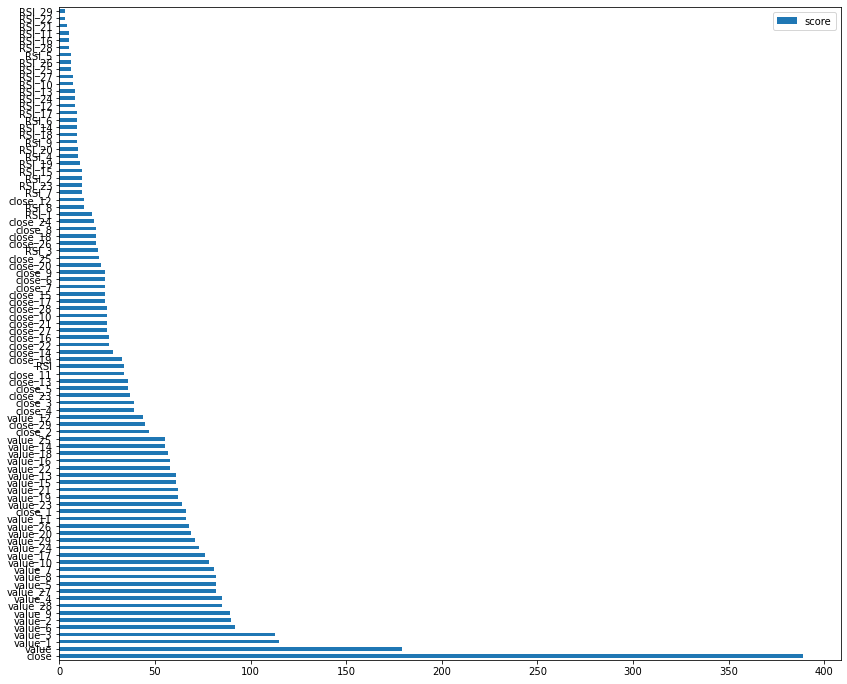

In [72]:
## 변수 중요도 확인
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

tmp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
tmp.plot(kind='barh', figsize=(14,12))

In [74]:
## LGBM을 활용한 머신러닝 적용

train, valid = train_test_split(Train, train_size=0.8,random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(train[cols], train['target'], train_size=0.8,random_state=42)
                                                      
## LGB
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_valid, label=y_valid)

## 파라미터 셋팅
params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'mae',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

## 모델 학습
model_t = lgb.train(params,
                train_ds,
                2000,
                val_ds,
                verbose_eval = 100,
                early_stopping_rounds = 100
                )

y_pred = model_t.predict(valid[cols])
print(mean_absolute_error(valid['target'], y_pred))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15360
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 90
[LightGBM] [Info] Start training from score 4.606275
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.280275
[200]	valid_0's l1: 0.274073
[300]	valid_0's l1: 0.272263
[400]	valid_0's l1: 0.271178
[500]	valid_0's l1: 0.270414
[600]	valid_0's l1: 0.270053
[700]	valid_0's l1: 0.269775
[800]	valid_0's l1: 0.26969
[900]	valid_0's l1: 0.269658
[1000]	valid_0's l1: 0.269657
Early stopping, best iteration is:
[964]	valid_0's l1: 0.269637
0.2930471049525254


In [75]:
## 성능 확인
print(mean_absolute_error(valid['target'].values, y_pred))

0.2930471049525254


In [76]:
## LGBM의 K-Fold 적용
train_set, valid_set = train_test_split(Train,train_size=0.85,random_state=42)
X_train = train_set[cols]
y_train = train_set['target']
X_valid = valid_set[cols]
y_valid = valid_set['target']

## 10 Fold Cross Validation
y_cat = pd.cut(y_train, 10, labels=range(10))
skf = KFold(5)

## 파라미터 셋팅
params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'mae',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }

preds = []
preds_test = []

i = 1
## 실제 학습 진행
for tr_id, val_id in skf.split(X_train, y_cat) : 
    X_tr = X_train[cols].iloc[tr_id]
    y_tr = y_train.iloc[tr_id]

    train_x, valid_x, train_y, valid_y = train_test_split(X_tr, y_tr, train_size=0.8,random_state=42)
    train_ds = lgb.Dataset(train_x, label=train_y)
    val_ds = lgb.Dataset(valid_x, label=valid_y)

    print('{}번째 학습'.format(i))
    model = lgb.train(params,
                  train_ds,
                  2000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 ) 
    pred = model.predict(X_valid[cols])
    preds.append(pred)
    i += 1

    pred_test = model.predict(Test[cols])
    preds_test.append(pred_test)

## 예측값 생성 및 점수 확인
model_pred = np.mean(preds, axis = 0)
print(mean_absolute_error(y_valid, model_pred))

1번째 학습
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15360
[LightGBM] [Info] Number of data points in the train set: 1254, number of used features: 90
[LightGBM] [Info] Start training from score 4.606436
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.303946
[200]	valid_0's l1: 0.302053
[300]	valid_0's l1: 0.299275
[400]	valid_0's l1: 0.299095
[500]	valid_0's l1: 0.299264
Early stopping, best iteration is:
[408]	valid_0's l1: 0.299033
2번째 학습
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15360
[LightGBM] [Info] Number of data points in the train set: 1254, number of used features: 90
[LightGBM] [Info] Start training from score 4.606344
Training until validation

### 결과 확인

In [77]:
## 최종 예측된 데이터셋 생성
final_pred = np.mean(preds_test, axis = 0)

final = pd.DataFrame()
final['coin'] = Test['name']
final['date'] = Test['date']
final['preds'] = final_pred

In [78]:
Test

,date,name,close,value,RSI,close_1,value_1,RSI_1,close_2,value_2,RSI_2,close_3,value_3,RSI_3,close_4,value_4,RSI_4,close_5,value_5,RSI_5,close_6,value_6,RSI_6,close_7,value_7,RSI_7,close_8,value_8,RSI_8,close_9,value_9,RSI_9,close_10,value_10,RSI_10,close_11,value_11,RSI_11,close_12,value_12,RSI_12,close_13,value_13,RSI_13,close_14,value_14,RSI_14,close_15,value_15,RSI_15,close_16,value_16,RSI_16,close_17,value_17,RSI_17,close_18,value_18,RSI_18,close_19,value_19,RSI_19,close_20,value_20,RSI_20,close_21,value_21,RSI_21,close_22,value_22,RSI_22,close_23,value_23,RSI_23,close_24,value_24,RSI_24,close_25,value_25,RSI_25,close_26,value_26,RSI_26,close_27,value_27,RSI_27,close_28,value_28,RSI_28,close_29,value_29,RSI_29,target
0,202301170000,BTC,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,25881000.0,0.025026,0.0,25887000.0,0.021436,0.0,25892000.0,0.023871,0.0,100.0
1,202301170005,BTC,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,25881000.0,0.025026,0.0,25887000.0,0.021436,0.0,100.0
2,202301170010,BTC,25755000.0,0.103477,0.0,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,25881000.0,0.025026,0.0,100.0
3,202301170015,BTC,25893000.0,0.051107,1.0,25755000.0,0.103477,0.0,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946000.0,0.043504,1.0,25926000.0,0.018807,1.0,25916000.0,0.029377,1.0,25889000.0,0.018943,0.0,25930000.0,0.025035,1.0,25916000.0,0.029950,0.0,25927000.0,0.031789,1.0,25863000.0,0.036353,1.0,25850000.0,0.029437,0.0,25874000.0,0.020246,0.0,25899000.0,0.014149,0.0,25911000.0,0.014991,1.0,25905000.0,0.025353,1.0,25899000.0,0.016868,1.0,25880000.0,0.030810,1.0,25843000.0,0.016386,0.0,25843000.0,0.017365,1.0,25820000.0,0.024330,1.0,25815000.0,0.023452,0.0,25831000.0,0.023207,0.0,100.0
4,202301170020,BTC,26012000.0,0.075129,1.0,25893000.0,0.051107,1.0,25755000.0,0.103477,0.0,25935000.0,0.033776,0.0,25939000.0,0.018551,0.0,25945000.0,0.004465,0.0,25967000.0,0.022202,0.0,25977000.0,0.012136,1.0,25950000.0,0.021691,0.0,25960000.0,0.024834,0.0,25970000.0,0.026820,1.0,25946

In [79]:
final.iloc[-12:]


,coin,date,preds
532,BTC,202301182020,99.907356
533,BTC,202301182025,99.910781
534,BTC,202301182030,99.886754
535,BTC,202301182035,99.746733
536,BTC,202301182040,99.752037
537,BTC,202301182045,99.832622
538,BTC,202301182050,99.849722
539,BTC,202301182055,99.767865
540,BTC,202301182100,99.781647
541,BTC,202301182105,99.845096


## table에 추가

In [ ]:
import pymysql

In [ ]:
## groups table에 추가
db = pymysql.connect(
                    host= "us-cdbr-east-06.cleardb.net",
                    user= "bbcbf72b01656b",
                    passwd= "f69cff64",
                    db= "heroku_c3b4550615fb803",
                    charset='utf8'
                    )

cursor = db.cursor()

for idx, i in enumerate(range(-12, -2)):
    date = final.iloc[i]['date']
    preds = final.iloc[i]['preds']
    
    pred_for_next = int(Test[Test['date'] == date]['close'] * preds) // 100
    print(idx, pred_for_next)

    # SQL 문 만들기
    sql = f'''UPDATE groups SET ai_price_{idx+1} = {pred_for_next} WHERE group_type = 1'''
    
    # SQL 실행하기
    cursor.execute(sql)
    results = cursor.fetchall()
    
    # 실행 mysql 서버에 확정 반영하기
    db.commit()

# DB 연결 닫기
db.close()

In [ ]:
db_date_list = []

In [ ]:
## bitcoin_price table에 추가

db = pymysql.connect(
  host= "us-cdbr-east-06.cleardb.net",
  user= "bbcbf72b01656b",
  password= "f69cff64",
  database= "heroku_c3b4550615fb803"
)

cursor = db.cursor()

for idx, i in enumerate(range(-12, -2)):
    date = final.iloc[i]['date']
    preds = final.iloc[i]['preds']
    
    pred_for_next = int(Test[Test['date'] == date]['close'] * preds) // 100
    pred_date = str(int(date)+100)
    db_date_list.append(pred_date)
    print(pred_date)
    print(idx, pred_for_next)
    print()
    
    
    # SQL 문 만들기
    sql = f'''UPDATE bitcoin_price SET ai_recommendation = {pred_for_next}, timestamp = {pred_date} WHERE test_num = {idx+1}'''
    
    # SQL 실행하기
    cursor.execute(sql)
    results = cursor.fetchall()
    
    # 실행 mysql 서버에 확정 반영하기
    db.commit()

# DB 연결 닫기
db.close()

## Real Price 계산 및 db 추가

In [75]:
db_date_list

['202301181915',
 '202301181920',
 '202301181925',
 '202301181930',
 '202301181935',
 '202301181940',
 '202301181945',
 '202301181950',
 '202301181955',
 '202301182000']

In [71]:
from datetime import datetime

now = datetime.now()

year = str(now.year)

if len(str(now.month)) == 1:
    month = str(0) + str(now.month)
else:
    month = str(now.month)

if len(str(now.day)) == 1:
    day = str(0) + str(now.day)
else:
    day = str(now.day)
    
if len(str(now.hour)) == 1:
    hour = str(0) + str(now.hour)
else:
    hour = str(now.hour)
    
if len(str(now.minute)) == 1:
    minute = str(0) + str(now.minute)
else:
    minute = str(now.minute)
    
current_date = year + month + day + hour + minute

In [81]:
import requests
response = requests.get('https://api.upbit.com/v1/candles/minutes/5?market=KRW-BTC&count=100')
json_response = response.json()

db = pymysql.connect(
  host= "us-cdbr-east-06.cleardb.net",
  user= "bbcbf72b01656b",
  password= "f69cff64",
  database= "heroku_c3b4550615fb803"
)

cursor = db.cursor()

for element in json_response:
    date = element['candle_date_time_kst']
    trade_price = element['trade_price']

    str_date = date[0:4] + date[5:7] + date[8:10] + date[11:13] + date[14:16]
    
    if str_date in db_date_list:
        print(str_date)
        print(trade_price)
        print()
        
        db_date_list.remove(str_date)
        
        # SQL 문 만들기
        sql = f'''UPDATE bitcoin_price SET price = {trade_price} WHERE timestamp = {str_date}'''

        # SQL 실행하기
        cursor.execute(sql)
        results = cursor.fetchall()

        # 실행 mysql 서버에 확정 반영하기
        db.commit()

# DB 연결 닫기
db.close()


202301182000
26338000.0

202301181955
26325000.0

202301181950
26352000.0

202301181945
26332000.0

202301181940
26327000.0

202301181935
26341000.0

202301181930
26335000.0

202301181925
26355000.0

202301181920
26356000.0

202301181915
26350000.0



### 아직 추가되지 않은 price에 대해, while문으로 반복

In [85]:
import time

In [90]:
t0 = time.time()

while db_date_list:
    # 5분마다 실행
    
    if time.time() - t0 < 300:
        continue
        
    print("Processing...")
    
    response = requests.get('https://api.upbit.com/v1/candles/minutes/5?market=KRW-BTC&count=5')
    json_response = response.json()

    db = pymysql.connect(
      host= "us-cdbr-east-06.cleardb.net",
      user= "bbcbf72b01656b",
      password= "f69cff64",
      database= "heroku_c3b4550615fb803"
    )

    cursor = db.cursor()
    
    for element in json_response:
        date = element['candle_date_time_kst']
        trade_price = element['trade_price']

        str_date = date[0:4] + date[5:7] + date[8:10] + date[11:13] + date[14:16]

        if str_date in db_date_list:
            print(str_date)
            print(trade_price)
            print()

            db_date_list.remove(str_date)

            # SQL 문 만들기
            sql = f'''UPDATE bitcoin_price SET price = {trade_price} WHERE timestamp = {str_date}'''

            # SQL 실행하기
            cursor.execute(sql)
            results = cursor.fetchall()

            # 실행 mysql 서버에 확정 반영하기
            db.commit()
    
    t0 = time.time()
    
    # DB 연결 닫기
    db.close()